<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.2 MB/s eta 0:00:00


In [2]:
%pip install statstests

In [3]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para Modelagem
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from statstests.process import stepwise
from sklearn.preprocessing import MinMaxScaler
from statsmodels.iolib.summary2 import summary_col
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

# Bibliotecas para Otimização
import deap
import random
from tqdm import tqdm
from functools import partial
from deap import base, creator, tools, algorithms

filterwarnings('ignore')

In [4]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Mounted at /content/drive


In [5]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [6]:
df.head()

,date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,...,category_arts_entertainment_recreation,category_travel_hospitality,category_professional_business_services,category_health_medical,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,2010-01-01 00:00:00,6,0,15.875000,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 00:15:00,4,0,22.262500,22.245049,0.012927,-1.980469,49.500000,16.663333,-0.134765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01 00:30:00,10,0,34.644000,45.188942,-0.779579,0.460440,48.600000,4.993329,-0.461034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.500000,18.251027,0.262932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.483960,54.500000,9.648834,0.573632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344191 entries, 0 to 344190
Data columns (total 61 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   date_window                              344191 non-null  datetime64[us]
 1   transactions                             344191 non-null  uint32        
 2   frauds                                   344191 non-null  int32         
 3   mean_amount                              344191 non-null  float64       
 4   std_amount                               342118 non-null  float64       
 5   skew_amount                              342116 non-null  float64       
 6   kurtosis_amount                          342116 non-null  float64       
 7   mean_current_age                         344191 non-null  float64       
 8   std_current_age                          342118 non-null  float64       
 9   skew_current_age          

In [8]:
df.describe()

,date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,...,category_arts_entertainment_recreation,category_travel_hospitality,category_professional_business_services,category_health_medical,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
count,344191,344191.000000,344191.000000,344191.000000,342118.000000,342116.000000,342116.000000,344191.000000,342118.000000,341971.000000,...,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000
mean,2014-12-01 22:29:15.840797,25.901209,0.038734,46.689266,71.645585,0.846947,3.798932,53.815317,15.191513,0.429373,...,0.019333,0.005556,0.008239,0.065248,0.008009,0.004446,0.000420,0.028306,0.012966,0.008028
min,2010-01-01 00:00:00,1.000000,0.000000,-488.000000,0.000000,-5.390673,-2.000000,23.500000,0.000000,-1.980365,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-17 14:22:30,9.000000,0.000000,32.612523,44.095898,0.000000,0.060794,51.423077,13.641248,0.201530,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014-12-01 23:15:00,25.000000,0.000000,42.730227,57.067318,0.750348,1.637112,53.833333,15.423287,0.454744,...,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017-05-17 22:07:30,40.000000,0.000000,55.543170,83.405991,1.630688,5.125906,56.187500,17.018589,0.689205,...,0.020000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000
max,2019-10-31 23:45:00,75.000000,5.000000,2014.420000,2347.052609,7.488300,55.037830,99.000000,51.618795,2.661910,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,16.207450,0.230214,28.805452,49.447956,1.569915,6.264675,4.628763,3.397723,0.425949,...,0.042678,0.028832,0.034438,0.074635,0.028369,0.020702,0.006123,0.053458,0.041687,0.019616


In [9]:
df['frauds'].value_counts(normalize=True)

,proportion
frauds,
0,0.968024
1,0.026183
2,0.004977
3,0.000680
4,0.000125
5,0.000012


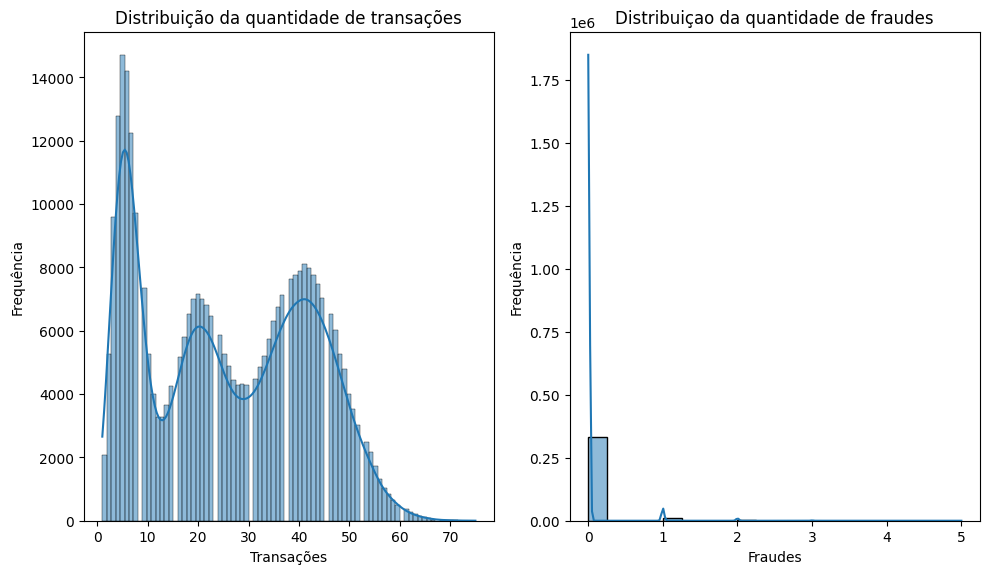

In [10]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title('Distribuição da quantidade de transações')
sns.histplot(df['transactions'], kde=True)
plt.xlabel('Transações')
plt.ylabel('Frequência')

plt.subplot(122)
plt.title('Distribuiçao da quantidade de fraudes')
sns.histplot(df['frauds'], kde=True)
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, 6, 1))

plt.tight_layout()
plt.show()

## Implementação de Modelos

In [11]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [12]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.038734,0.052999


Há indícios de superdispersão.

In [13]:
all_features = df.drop(columns=['frauds', 'date_window']).columns.to_list()
all_features[0:3]

['transactions', 'mean_amount', 'std_amount']

In [14]:
features_completa_formula = 'frauds ~ ' + ' + '.join(all_features)
features_completa_formula

'frauds ~ transactions + mean_amount + std_amount + skew_amount + kurtosis_amount + mean_current_age + std_current_age + skew_current_age + kurtosis_current_age + mean_per_capita_income + std_per_capita_income + skew_per_capita_income + kurtosis_per_capita_income + mean_total_debt + std_total_debt + skew_total_debt + kurtosis_total_debt + mean_credit_score + std_credit_score + skew_credit_score + kurtosis_credit_score + mean_num_credit_cards + std_num_credit_cards + skew_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + std_credit_limit + skew_credit_limit + kurtosis_credit_limit + use_chip_online_transaction + use_chip_swipe_transaction + use_chip_chip_transaction + gender_female + card_brand_visa + card_brand_mastercard + card_brand_amex + card_brand_discover + card_type_debit + card_type_credit + card_type_debit_prepaid + has_chip_no + online_sales_no + category_transportation_logistics + category_financial_insurance + category_food_beverage + category_retail_genera

In [15]:
modelo_poison_simple = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               344191
Model:                            GLM   Df Residuals:                   344189
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53299.
Date:                Sun, 25 May 2025   Deviance:                       83242.
Time:                        19:17:03   Pearson chi2:                 4.08e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02942
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2258      0.027   -192.547      0.000      -5.279      -5.173
transactions     0.0593      0.001     91.760      0.000       0.058       0.061
================================================================================
"""

Observações do modelo simples

* Intercepto e variavel `transactions` são estatisticamente significantes
* O Log-Likelihood é alto
* Pseudo R-Squ. (CS) indique que apenas a variavel `transaction` explica menos que 3% da variância na contagem de fraudes.



In [16]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=df, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               340559
Model:                            GLM   Df Residuals:                   340499
Model Family:                 Poisson   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51517.
Date:                Sun, 25 May 2025   Deviance:                       79699.
Time:                        19:17:09   Pearson chi2:                 3.80e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03882
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -6.9361      3.785     -1.832      0.067     -14.355       0.483
transactions                                0.0663      0.001     73.883      0.000       0.065       0.068
mean_amount                                -0.0003      0.001     -0.623      0.534      -0.001       0.001
std_amount                                  0.0022      0.000      7.677      0.000       0.002       0.003
skew_amount                                 0.0605      0.007      8.675      0.000       0.047       0.074
kurtosis_amount                            -0.0065      0.002     -3.759      0.000      -0.010      -0.003
mean_current_age                            0.0087      0.004      2.346      0.019       0.001       0.016
std_current_age                            -0.0118      0.005     -2.434      0.015      -0.021      -0.002
skew_current_age                            0.1414      0.042      3.337      0.001       0.058       0.224
kurtosis_current_age                       -0.0887      0.021     -4.128      0.000      -0.131      -0.047
mean_per_capita_income                  -9.577e-06   7.58e-06     -1.264      0.206   -2.44e-05    5.27e-06
std_per_capita_income                    -7.93e-07   4.52e-06     -0.175      0.861   -9.66e-06    8.07e-06
skew_per_capita_income                      0.1473      0.027      5.550      0.000       0.095       0.199
kurtosis_per_capita_income                 -0.0254      0.004     -5.653      0.000      -0.034      -0.017
mean_total_debt                         -3.741e-07    1.6e-06     -0.234      0.815   -3.51e-06    2.76e-06
std_total_debt                          -1.145e-06   1.62e-06     -0.706      0.480   -4.33e-06    2.04e-06
skew_total_debt                             0.2409      0.044      5.501      0.000       0.155       0.327
kurtosis_total_debt                        -0.0452      0.008     -5.956      0.000      -0.060      -0.030
mean_credit_score                          -0.0017      0.001     -2.297      0.022      -0.003      -0.000
std_credit_score                           -0.0004      0.001     -0.431      0.666      -0.002       0.001
skew_credit_score                           0.0890      0.027      3.307      0.001       0.036       0.142
kurtosis_credit_score                       0.0942      0.012      8.142      0.000       0.071       0.117
mean_num_credit_cards                       0.1358      0.032      4.210      0.000       0.073       0.199
std_num_credit_cards                       -0.0922      0.043     -2.148      0.032      -0.176      -0.008
skew_num_credit_cards                       0.0424      0.031      1.351      0.177      -0.019       0.104
kurtosis_num_credit_cards                   0.0588      0.0

In [17]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.002       
Dependent Variable:     ystar            AIC:                         2012004.0612
Date:                   2025-05-25 19:17 BIC:                         2012014.7995
No. Observations:       340559           Log-Likelihood:              -1.0060e+06 
Df Model:               1                F-statistic:                 707.2       
Df Residuals:           340558           Prob (F-statistic):          1.17e-155   
R-squared (uncentered): 0.002            Scale:                       21.543      
----------------------------------------------------------------------------------------
              Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
----------------------------------------------------------------------------------------
lmbda         3.5408         0.1331       26.5933       0.0000      

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

In [18]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('skew_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('skew_current_age') + Q('kurtosis_current_age') + Q('mean_per_capita_income') + Q('std_per_capita_income') + Q('skew_per_capita_income') + Q('kurtosis_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('skew_total_debt') + Q('kurtosis_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('skew_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('std_credit_limit') + Q('skew_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_online_transaction') + Q('use_chip_swipe_transaction') + Q('use_chip_chip_transaction') + Q('gender_female') + Q('card_brand_visa') + Q('card_brand_mastercard') + Q('card_brand_amex') + Q('car

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               340559
Model:                            GLM   Df Residuals:                   340524
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51532.
Date:                Sun, 25 May 2025   Deviance:                       79729.
Time:                        19:19:10   Pearson chi2:                 3.80e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03874
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -6.4967      0.199    -32.688      0.000      -6.886      -6.107
Q('transactions')                                0.0663      0.001     76.061      0.000       0.065       0.068
Q('std_amount')                                  0.0021      0.000     10.921      0.000       0.002       0.002
Q('skew_amount')                                 0.0598      0.007      9.095      0.000       0.047       0.073
Q('kurtosis_amount')                            -0.0063      0.002     -4.004      0.000      -0.009      -0.003
Q('mean_current_age')                            0.0094      0.003      2.736      0.006       0.003       0.016
Q('std_current_age')                            -0.0138      0.005     -2.997      0.003      -0.023      -0.005
Q('skew_current_age')                            0.1396      0.042      3.326      0.001       0.057       0.222
Q('kurtosis_current_age')                       -0.0944      0.021     -4.446      0.000      -0.136      -0.053
Q('mean_per_capita_income')                  -1.172e-05   5.03e-06     -2.328      0.020   -2.16e-05   -1.85e-06
Q('skew_per_capita_income')                      0.1435      0.025      5.660      0.000       0.094       0.193
Q('kurtosis_per_capita_income')                 -0.0254      0.004     -5.884      0.000      -0.034      -0.017
Q('skew_total_debt')                             0.2265      0.036      6.377      0.000       0.157       0.296
Q('kurtosis_total_debt')                        -0.0450      0.007     -6.266      0.000      -0.059      -0.031
Q('skew_credit_score')                           0.0867      0.024      3.590      0.000       0.039       0.134
Q('kurtosis_credit_score')                       0.0946      0.011      8.705      0.000       0.073       0.116
Q('mean_num_credit_cards')                       0.1114      0.030      3.691      0.000       0.052       0.171
Q('kurtosis_num_credit_cards')                   0.0753      0.013      5.644      0.000       0.049       0.101
Q('mean_credit_limit')                       -1.924e-05   4.78e-06     -4.027      0.000   -2.86e-05   -9.88e-06
Q('skew_credit_limit')                           0.0332      0.011      2.955      0.003       0.011       0.055
Q('use_chip_online_transaction')                 5.9051      0.128     46.159      0.000       5.654       6.156
Q('use_chip_swipe_transaction')                 -0.3116      0.026    -12.192      0.000      -0.362      -0.262
Q('gender_female')                               0.3781      0.086      4.405      0.000       0.210       0.546
Q('card_brand_amex')                            -0.4116      0.177     -2.319      0.020      -0.759      -0.064
Q('category_transportation_logis

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [19]:
overdisp(modelo_poisson_stepswise, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.002       
Dependent Variable:     ystar            AIC:                         2017292.6013
Date:                   2025-05-25 19:19 BIC:                         2017303.3396
No. Observations:       340559           Log-Likelihood:              -1.0086e+06 
Df Model:               1                F-statistic:                 698.2       
Df Residuals:           340558           Prob (F-statistic):          1.07e-153   
R-squared (uncentered): 0.002            Scale:                       21.880      
----------------------------------------------------------------------------------------
              Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
----------------------------------------------------------------------------------------
lmbda         3.5461         0.1342       26.4230       0.0000      

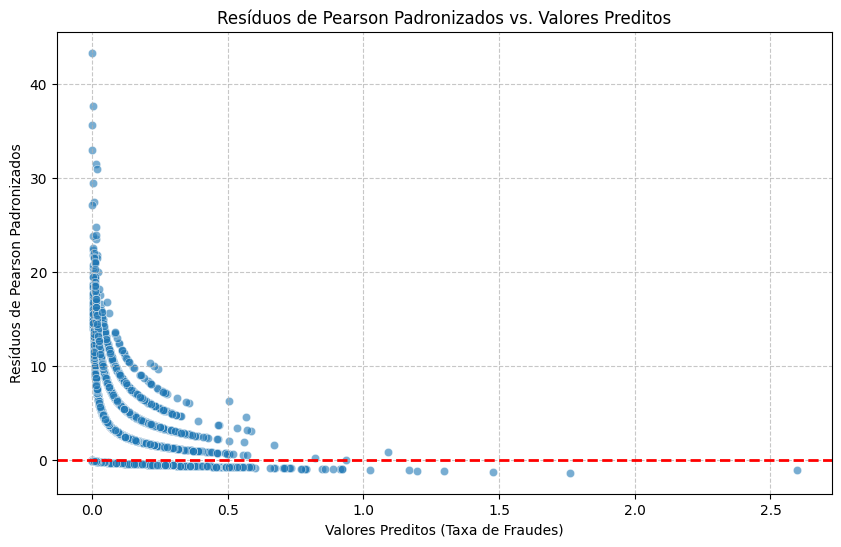

In [20]:
pearson_residuals = modelo_poisson_stepswise.resid_pearson
fitted_values = modelo_poisson_stepswise.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Valores Preditos (Taxa de Fraudes)")
plt.ylabel("Resíduos de Pearson Padronizados")
plt.title("Resíduos de Pearson Padronizados vs. Valores Preditos")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [21]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-5.2258***,-6.9361*,-6.4967***
,(0.0271),(3.7851),(0.1987)
transactions,0.0593***,0.0663***,
,(0.0006),(0.0009),
mean_amount,,-0.0003,
,,(0.0005),
std_amount,,0.0022***,
,,(0.0003),
skew_amount,,0.0605***,
,,(0.0070),


### Binomial Negative (Poisson-Gama)

In [22]:
modelo_binomialneg_simples = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               344191
Model:                            GLM   Df Residuals:                   344189
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51976.
Date:                Sun, 25 May 2025   Deviance:                       71133.
Time:                        19:19:11   Pearson chi2:                 3.92e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02838
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2435      0.028   -189.079      0.000      -5.298      -5.189
transactions     0.0598      0.001     89.713      0.000       0.059       0.061
================================================================================
"""

In [23]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=df, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               340559
Model:                            GLM   Df Residuals:                   340499
Model Family:        NegativeBinomial   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50297.
Date:                Sun, 25 May 2025   Deviance:                       67804.
Time:                        19:19:18   Pearson chi2:                 3.64e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.03722
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -7.4714      3.940     -1.896      0.058     -15.193       0.250
transactions                                0.0668      0.001     71.080      0.000       0.065       0.069
mean_amount                                -0.0004      0.001     -0.720      0.471      -0.002       0.001
std_amount                                  0.0023      0.000      7.612      0.000       0.002       0.003
skew_amount                                 0.0604      0.007      8.285      0.000       0.046       0.075
kurtosis_amount                            -0.0067      0.002     -3.664      0.000      -0.010      -0.003
mean_current_age                            0.0090      0.004      2.344      0.019       0.001       0.017
std_current_age                            -0.0125      0.005     -2.471      0.013      -0.022      -0.003
skew_current_age                            0.1515      0.044      3.462      0.001       0.066       0.237
kurtosis_current_age                       -0.0913      0.022     -4.109      0.000      -0.135      -0.048
mean_per_capita_income                  -9.957e-06   7.86e-06     -1.268      0.205   -2.54e-05    5.44e-06
std_per_capita_income                   -1.257e-06    4.7e-06     -0.267      0.789   -1.05e-05    7.96e-06
skew_per_capita_income                      0.1479      0.027      5.396      0.000       0.094       0.202
kurtosis_per_capita_income                 -0.0255      0.005     -5.456      0.000      -0.035      -0.016
mean_total_debt                         -3.359e-07   1.65e-06     -0.203      0.839   -3.58e-06    2.91e-06
std_total_debt                          -1.228e-06   1.69e-06     -0.728      0.467   -4.53e-06    2.08e-06
skew_total_debt                             0.2404      0.045      5.309      0.000       0.152       0.329
kurtosis_total_debt                        -0.0449      0.008     -5.705      0.000      -0.060      -0.029
mean_credit_score                          -0.0017      0.001     -2.201      0.028      -0.003      -0.000
std_credit_score                           -0.0002      0.001     -0.249      0.804      -0.002       0.002
skew_credit_score                           0.0852      0.028      3.066      0.002       0.031       0.140
kurtosis_credit_score                       0.0930      0.012      7.746      0.000       0.069       0.117
mean_num_credit_cards                       0.1390      0.033      4.155      0.000       0.073       0.205
std_num_credit_cards                       -0.0867      0.045     -1.947      0.052      -0.174       0.001
skew_num_credit_cards                       0.0485      0.032      1.498      0.134      -0.015       0.112
kurtosis_num_credit_cards                   0.0584      0.0

In [24]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('skew_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('skew_current_age') + Q('kurtosis_current_age') + Q('mean_per_capita_income') + Q('std_per_capita_income') + Q('skew_per_capita_income') + Q('kurtosis_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('skew_total_debt') + Q('kurtosis_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('skew_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('std_credit_limit') + Q('skew_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_online_transaction') + Q('use_chip_swipe_transaction') + Q('use_chip_chip_transaction') + Q('gender_female') + Q('card_brand_visa') + Q('card_brand_mastercard') + Q('card_brand_amex') + Q('car

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               340559
Model:                            GLM   Df Residuals:                   340524
Model Family:        NegativeBinomial   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50310.
Date:                Sun, 25 May 2025   Deviance:                       67831.
Time:                        19:21:38   Pearson chi2:                 3.66e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.03714
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -6.8734      0.208    -32.970      0.000      -7.282      -6.465
Q('transactions')                                0.0669      0.001     73.148      0.000       0.065       0.069
Q('std_amount')                                  0.0022      0.000     10.212      0.000       0.002       0.003
Q('skew_amount')                                 0.0593      0.007      8.712      0.000       0.046       0.073
Q('kurtosis_amount')                            -0.0063      0.002     -3.818      0.000      -0.010      -0.003
Q('mean_current_age')                            0.0096      0.004      2.709      0.007       0.003       0.017
Q('std_current_age')                            -0.0143      0.005     -2.989      0.003      -0.024      -0.005
Q('skew_current_age')                            0.1505      0.043      3.472      0.001       0.066       0.235
Q('kurtosis_current_age')                       -0.0970      0.022     -4.420      0.000      -0.140      -0.054
Q('mean_per_capita_income')                  -1.267e-05   5.21e-06     -2.430      0.015   -2.29e-05   -2.45e-06
Q('skew_per_capita_income')                      0.1437      0.026      5.486      0.000       0.092       0.195
Q('kurtosis_per_capita_income')                 -0.0255      0.004     -5.694      0.000      -0.034      -0.017
Q('skew_total_debt')                             0.2240      0.037      6.110      0.000       0.152       0.296
Q('kurtosis_total_debt')                        -0.0445      0.007     -5.979      0.000      -0.059      -0.030
Q('skew_credit_score')                           0.0806      0.025      3.231      0.001       0.032       0.130
Q('kurtosis_credit_score')                       0.0925      0.011      8.180      0.000       0.070       0.115
Q('mean_num_credit_cards')                       0.1147      0.031      3.659      0.000       0.053       0.176
Q('kurtosis_num_credit_cards')                   0.0763      0.014      5.495      0.000       0.049       0.103
Q('mean_credit_limit')                       -1.843e-05   4.94e-06     -3.729      0.000   -2.81e-05   -8.74e-06
Q('skew_credit_limit')                           0.0319      0.012      2.721      0.007       0.009       0.055
Q('use_chip_online_transaction')                 6.3008      0.134     47.121      0.000       6.039       6.563
Q('use_chip_chip_transaction')                   0.3097      0.027     11.683      0.000       0.258       0.362
Q('gender_female')                               0.3986      0.089      4.483      0.000       0.224       0.573
Q('card_brand_amex')                            -0.3999      0.184     -2.175      0.030      -0.760      -0.040
Q('category_transportation_logis

In [25]:
lrtest([modelo_poisson_stepswise, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): 2443.93
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


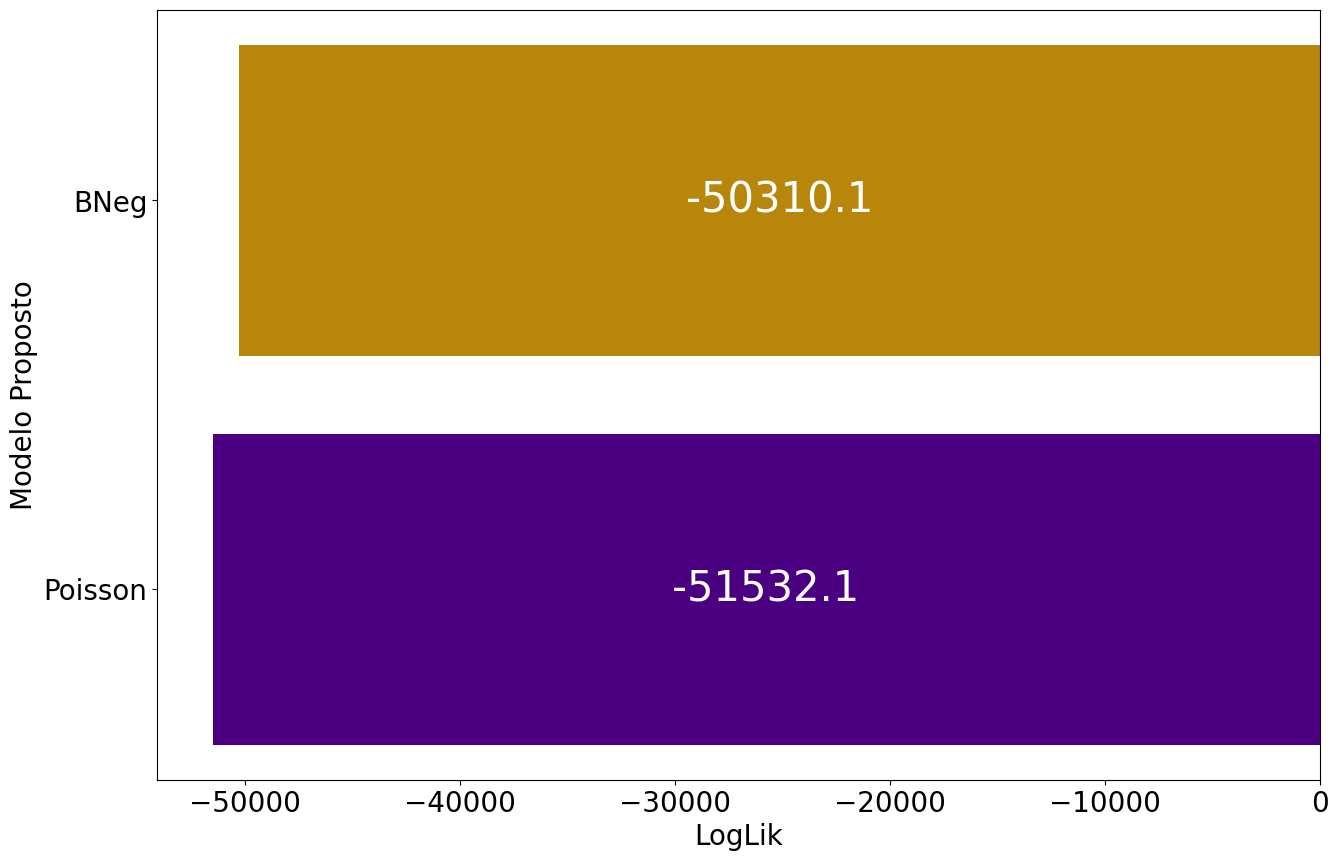

In [26]:
df_llf = pd.DataFrame({'modelo':['Poisson','BNeg'],
                      'loglik':[modelo_poisson_stepswise.llf, modelo_binomialneg_stepwise.llf]})
# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(15,10))

c = ['indigo', 'darkgoldenrod']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
ax.set_ylabel("Modelo Proposto", fontsize=20)
ax.set_xlabel("LogLik", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

### Zero Inflated Poison

In [27]:
y = df['frauds'].copy()
X1 = df['transactions'].copy()
X1 = sm.add_constant(X1)

In [28]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_simples.summary()

         Current function value: 0.147460
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 49


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:               344191
Model:             ZeroInflatedPoisson   Df Residuals:                   344189
Method:                            MLE   Df Model:                            1
Date:                 Sun, 25 May 2025   Pseudo R-squ.:                 0.07529
Time:                         19:21:52   Log-Likelihood:                -50755.
converged:                       False   LL-Null:                       -54887.
Covariance Type:             nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            3.4067      0.032    105.102      0.000       3.343       3.470
inflate_transactions    -0.0423      0.001    -52.253      0.000      -0.044      -0.041
const                   -1.8998      0.031    -60.890      0.000      -1.961      -1.839
transactions             0.0237      0.001     31.289      0.000       0.022       0.025
========================================================================================
"""

In [29]:
modelo_zinb_simples = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_simples.summary()


         Current function value: 0.147255
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 47


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:               344191
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                   344189
Method:                                      MLE   Df Model:                            1
Date:                           Sun, 25 May 2025   Pseudo R-squ.:                 0.07648
Time:                                   19:22:44   Log-Likelihood:                -50684.
converged:                                 False   LL-Null:                       -54881.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            2.3290      0.125     18.687      0.000       2.085       2.573
inflate_transactions    -0.0879      0.004    -23.236      0.000      -0.095      -0.080
const                   -3.5597      0.123    -28.957      0.000      -3.801      -3.319
transactions             0.0272      0.002     12.501      0.000       0.023       0.032
alpha                    4.0671      0.235     17.293      0.000       3.606       4.528
========================================================================================
"""

In [30]:
df.columns

Index(['date_window', 'transactions', 'frauds', 'mean_amount', 'std_amount',
       'skew_amount', 'kurtosis_amount', 'mean_current_age', 'std_current_age',
       'skew_current_age', 'kurtosis_current_age', 'mean_per_capita_income',
       'std_per_capita_income', 'skew_per_capita_income',
       'kurtosis_per_capita_income', 'mean_total_debt', 'std_total_debt',
       'skew_total_debt', 'kurtosis_total_debt', 'mean_credit_score',
       'std_credit_score', 'skew_credit_score', 'kurtosis_credit_score',
       'mean_num_credit_cards', 'std_num_credit_cards',
       'skew_num_credit_cards', 'kurtosis_num_credit_cards',
       'mean_credit_limit', 'std_credit_limit', 'skew_credit_limit',
       'kurtosis_credit_limit', 'use_chip_online_transaction',
       'use_chip_swipe_transaction', 'use_chip_chip_transaction',
       'gender_female', 'card_brand_visa', 'card_brand_mastercard',
       'card_brand_amex', 'card_brand_discover', 'card_type_debit',
       'card_type_credit', 'card_type_de

In [31]:
exclude_columns = [column for column in df.columns if 'std_' in column]
exclude_columns.extend([column for column in df.columns if 'skew_' in column])
exclude_columns.extend([column for column in df.columns if 'kurtosis_' in column])

In [32]:
X = df.drop(columns=['date_window', 'frauds']).drop(columns=exclude_columns).copy(deep=True)

In [33]:
min_max = MinMaxScaler(feature_range=(0,1))
X_min_max = min_max.fit_transform(X)
X = pd.DataFrame(X_min_max, columns=X.columns)

In [34]:
X = sm.add_constant(X)

In [35]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X, exog_infl=X, inflation='logit').fit()
modelo_zip_complete.summary()

         Current function value: 0.146314
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:               344191
Model:             ZeroInflatedPoisson   Df Residuals:                   344152
Method:                            MLE   Df Model:                           38
Date:                 Sun, 25 May 2025   Pseudo R-squ.:                 0.08248
Time:                         19:23:33   Log-Likelihood:                -50360.
converged:                       False   LL-Null:                       -54887.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.4903      4.505      0.109      0.913      -8.339       9.320
inflate_transactions                               -1.9095      0.071    -27.068      0.000      -2.048      -1.771
inflate_mean_amount                                 0.1848      1.592      0.116      0.908      -2.936       3.306
inflate_mean_current_age                            0.1560      0.318      0.491      0.623      -0.467       0.779
inflate_mean_per_capita_income                      0.1466      1.100      0.133      0.894      -2.009       2.302
inflate_mean_total_debt                             0.2201      0.367      0.600      0.549      -0.499       0.940
inflate_mean_credit_score                           0.3389      0.307      1.104      0.269      -0.263       0.940
inflate_mean_num_credit_cards                       0.1946      0.316      0.617      0.538      -0.424       0.813
inflate_mean_credit_limit                           0.1523      0.870      0.175      0.861      -1.553       1.858
inflate_use_chip_online_transaction                -0.1082      3.421     -0.032      0.975      -6.813       6.596
inflate_use_chip_swipe_transaction                  0.4352      2.807      0.155      0.877      -5.066       5.936
inflate_use_chip_chip_transaction                   0.3624      2.806      0.129      0.897      -5.138       5.863
inflate_gender_female                               0.2113      0.108      1.959      0.050   -9.29e-05       0.423
inflate_card_brand_visa                             0.2685      2.143      0.125      0.900      -3.932       4.469
inflate_card_brand_mastercard                       0.2772      2.140      0.130      0.897      -3.917       4.472
inflate_card_brand_amex                             0.1369      2.148      0.064      0.949      -4.073       4.347
inflate_card_brand_discover                         0.1069      2.160      0.049      0.961      -4.127       4.341
inflate_card_type_debit                             0.3700      2.329      0.159      0.874      -4.195       4.935
inflate_card_type_credit                            0.2182      2.331      0.094      0.925      -4.350       4.786
inflate_card_type_debit_prepaid                     0.1009      2.333      0.043      0.966      -4.472       4.674
inflate_has_chip_no                                 0.0927      0.184      0.504      0.614      -0.268       0.453
inflate_online_sales_no                             0.6926      2.022      0.343      0.732      -3.270       4.655
inflate_category_transportation_logistics          -0.0594      0.978     -0.061      0.952      -1.977       1.858
inflate_category_financial_insurance                0.0950      1.000      0.095      0.924      -1.865       2.055
inflate_category_food_beverage                      0.3208      0.974      0.329      0.742      -1.

In [36]:
# class ZeroInflatedModelEvaluator:
#     """
#     Classe para treinar e avaliar modelos Zero-Inflated Poisson (ZIP)
#     e Zero-Inflated Negative Binomial (ZINB), com consideração de significância estatística.
#     """
#     def __init__(self, df: pd.DataFrame, dependent_var: str, independent_vars_names: list):
#         self.df = df
#         self.dependent_var = dependent_var
#         self.independent_vars_names = independent_vars_names
#         self.num_total_features = len(independent_vars_names)

#         missing_cols = [col for col in independent_vars_names if col not in self.df.columns]
#         if missing_cols:
#             raise ValueError(f"Variáveis independentes ausentes no DataFrame: {missing_cols}")
#         print(f"[Model Evaluator - Init] Inicializado para variável dependente: '{self.dependent_var}'.")

#     def evaluate_individual(self, individual: list, model_type: str = 'ZINB',
#                             p_value_threshold: float = 0.05,
#                             significance_penalty_factor: float = 100.0,
#                             return_model_summary: bool = False):
#         """
#         Avalia um indivíduo (combinação de features) treinando um modelo Zero-Inflated
#         e calculando seu fitness (AIC com penalidade de significância).

#         Args:
#             individual (list): Um indivíduo do algoritmo genético (cromossomo binário).
#             model_type (str): Tipo de modelo a ser treinado ('ZIP' ou 'ZINB').
#             p_value_threshold (float): Limiar de p-valor para significância estatística.
#             significance_penalty_factor (float): Fator de penalidade para variáveis não significantes.
#             return_model_summary (bool): Se True, retorna o objeto summary do modelo treinado.

#         Returns:
#             tuple: (fitness_value,) ou (fitness_value, model_results)
#         """
#         selected_features_count_idx = [i for i, gene in enumerate(individual[:self.num_total_features]) if gene == 1]
#         selected_features_zero_idx = [i for i, gene in enumerate(individual[self.num_total_features:]) if gene == 1]

#         features_count = [self.independent_vars_names[i] for i in selected_features_count_idx]
#         features_zero = [self.independent_vars_names[i] for i in selected_features_zero_idx]

#         # Logs das features selecionadas - atenção: estes prints aparecerão junto com a barra do tqdm
#         print(f"  [Model Evaluator - {model_type}] Features para Contagem: {features_count}")
#         print(f"  [Model Evaluator - {model_type}] Features para Zero-Inflated: {features_zero}")


#         if not selected_features_count_idx or not selected_features_zero_idx:
#             print(f"  [Model Evaluator - {model_type}] Indivíduo inválido: Não há features selecionadas para ambos os componentes. Fitness: inf.")
#             return (float('inf'),)

#         if not all(f in self.df.columns for f in features_count + features_zero):
#             print(f"  [Model Evaluator - {model_type}] Indivíduo inválido: Features ausentes no DataFrame. Fitness: inf.")
#             return (float('inf'),)

#         X_count = self.df[features_count]
#         X_zero = self.df[features_zero]
#         y = self.df[self.dependent_var]

#         try:
#             X_count_with_const = sm.add_constant(X_count, has_constant='add')
#             X_zero_with_const = sm.add_constant(X_zero, has_constant='add')

#             model = None
#             if model_type == 'ZIP':
#                 model = sm.ZeroInflatedPoisson(
#                     endog=y,
#                     exog=X_count_with_const,
#                     exog_infl=X_zero_with_const,
#                     inflation='logit'
#                 )
#                 print(f"  [Model Evaluator - {model_type}] Tentando treinar modelo Zero-Inflated Poisson.")
#             elif model_type == 'ZINB':
#                 model = sm.ZeroInflatedNegativeBinomialP(
#                     endog=y,
#                     exog=X_count_with_const,
#                     exog_infl=X_zero_with_const,
#                     inflation='logit'
#                 )
#                 print(f"  [Model Evaluator - {model_type}] Tentando treinar modelo Zero-Inflated Negative Binomial.")
#             else:
#                 print(f"  [Model Evaluator - {model_type}] ERRO: model_type '{model_type}' inválido. Deve ser 'ZIP' ou 'ZINB'.")
#                 raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")

#             # Treinar o modelo
#             result = model.fit()
#             print(f"  [Model Evaluator - {model_type}] Modelo treinado com sucesso. AIC: {result.aic:.4f}")

#             # Avaliar significância
#             non_significant_count_features = 0
#             if result.pvalues.get('exog') is not None:
#                 for feature_name, p_value in result.pvalues['exog'].items():
#                     if feature_name == 'const':
#                         continue
#                     if p_value > p_value_threshold:
#                         non_significant_count_features += 1
#                         print(f"    [Model Evaluator - {model_type}] Feature de Contagem NÃO SIGNIFICANTE: '{feature_name}' (p-valor: {p_value:.4f})")

#             non_significant_zero_features = 0
#             if result.pvalues.get('exog_infl') is not None:
#                 for feature_name, p_value in result.pvalues['exog_infl'].items():
#                     if feature_name == 'const':
#                         continue
#                     if p_value > p_value_threshold:
#                         non_significant_zero_features += 1
#                         print(f"    [Model Evaluator - {model_type}] Feature Zero-Inflated NÃO SIGNIFICANTE: '{feature_name}' (p-valor: {p_value:.4f})")

#             total_non_significant_features = non_significant_count_features + non_significant_zero_features
#             significance_penalty = total_non_significant_features * significance_penalty_factor

#             print(f"  [Model Evaluator - {model_type}] Penalidade por não significância: {total_non_significant_features} features não significantes * {significance_penalty_factor} = {significance_penalty:.2f}")

#             fitness_value = result.aic + significance_penalty
#             print(f"  [Model Evaluator - {model_type}] Fitness Calculado (AIC + Penalidade): {fitness_value:.4f}")

#             if return_model_summary:
#                 return (fitness_value, result)
#             return (fitness_value,)

#         except Exception as e:
#             print(f"  [Model Evaluator - {model_type}] ERRO ao treinar o modelo. Features Contagem: {features_count}, Features Zero-Inflated: {features_zero}. Erro: {e}")
#             return (float('inf'),)

In [38]:
y = df['frauds'].copy()
X = df.drop(columns=['date_window', 'frauds']).drop(columns=exclude_columns)

In [39]:
min_max = MinMaxScaler(feature_range=(0,1))
X_min_max = min_max.fit_transform(X)

X = pd.DataFrame(X_min_max, columns=X.columns)
X['frauds'] = y
X

,transactions,mean_amount,mean_current_age,mean_per_capita_income,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,...,category_travel_hospitality,category_professional_business_services,category_health_medical,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services,frauds
0,0.067568,0.201355,0.309051,0.134219,0.335060,0.759053,0.375000,0.057275,0.17,0.83,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
1,0.040541,0.203908,0.344371,0.150382,0.216818,0.650418,0.406250,0.100288,0.00,1.00,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
2,0.121622,0.208855,0.332450,0.132984,0.202050,0.583008,0.350000,0.157552,0.20,0.80,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
3,0.067568,0.201161,0.622517,0.121414,0.144503,0.783194,0.541667,0.139463,0.17,0.83,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
4,0.067568,0.235379,0.410596,0.161468,0.240880,0.666667,0.354167,0.184798,0.50,0.50,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344186,0.202703,0.227852,0.424669,0.123445,0.154490,0.600279,0.328125,0.097700,0.06,0.06,...,0.00,0.06,0.0,0.00,0.0,0.0,0.0,0.06,0.00,0
344187,0.027027,0.203514,0.328918,0.127208,0.150904,0.564531,0.291667,0.151123,0.00,0.33,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
344188,0.054054,0.209477,0.340397,0.165746,0.262058,0.522563,0.350000,0.143789,0.40,0.00,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0
344189,0.081081,0.251059,0.350993,0.143446,0.195149,0.685635,0.375000,0.095538,0.14,0.43,...,0.14,0.00,0.0,0.14,0.0,0.0,0.0,0.00,0.00,0


In [64]:
class ZeroInflatedModelEvaluat:
  def __init__(self, df: pd.DataFrame, dependent_var: str, independent_vars_names: list):
      self.df = df
      self.dependent_var = dependent_var
      self.independent_vars_names = independent_vars_names
      self.num_total_features = len(independent_vars_names)

      missing_cols = [col for col in independent_vars_names if col not in self.df.columns]
      if missing_cols:
          raise ValueError(f"Variáveis independentes ausentes no DataFrame: {missing_cols}")
      print(f"[Model Evaluator - Init] Inicializado para variável dependente: '{self.dependent_var}'.")

  def evaluate(self, individual: list,
                     model_type: str = 'ZIP',
                     p_value_threshold: float = 0.05,
                     significance_penalty_factor: float = 100.0,
                     return_model_summary: bool = False):
    selected_features_count_idx = [i for i, gene in enumerate(individual[:self.num_total_features]) if gene == 1]
    selected_features_zero_idx = [i for i, gene in enumerate(individual[self.num_total_features:]) if gene == 1]

    if not selected_features_count_idx or not selected_features_zero_idx:
        print(f"  [Model Evaluator - {model_type}] Indivíduo inválido: Não há features selecionadas para ambos os componentes. Fitness: inf.")
        return (float('inf'),)

    features_count = [self.independent_vars_names[i] for i in selected_features_count_idx]
    features_zero = [self.independent_vars_names[i] for i in selected_features_zero_idx]

    if not all(f in self.df.columns for f in features_count + features_zero):
      print(f"  [Model Evaluator - {model_type}] Indivíduo inválido: Features ausentes no DataFrame. Fitness: inf.")
      return (float('inf'),)

    # Logs das features selecionadas - atenção: estes prints aparecerão junto com a barra do tqdm
    print(f"  [Model Evaluator - {model_type}] Features para Contagem: {features_count}")
    print(f"  [Model Evaluator - {model_type}] Features para Zero-Inflated: {features_zero}")

    model = None
    if model_type == 'ZIP':
      model = sm.ZeroInflatedPoisson(
          endog=self.df[self.dependent_var],
          exog=self.df[features_count],
          exog_infl=self.df[features_zero],
          inflation='logit'
      )
    elif model_type == 'ZINB':
     model = sm.ZeroInflatedNegativeBinomialP(
          endog=self.df[self.dependent_var],
          exog=self.df[features_count],
          exog_infl=self.df[features_zero],
          inflation='logit'
      )
    else:
      raise ValueError(f"Tipo de modelo inválido: {model_type}")
    model = model.fit()

    print(f"  [Model Evaluator - {model_type}] Modelo treinado com sucesso. AIC: {model.aic:.4f}")
    non_significant_count_features = 0
    if model.pvalues.get('exog') is not None:
        for feature_name, p_value in model.pvalues['exog'].items():
            if feature_name == 'const':
                continue
            if p_value > p_value_threshold:
                non_significant_count_features += 1
                print(f"    [Model Evaluator - {model_type}] Feature de Contagem NÃO SIGNIFICANTE: '{feature_name}' (p-valor: {p_value:.4f})")

    non_significant_zero_features = 0
    if model.pvalues.get('exog_infl') is not None:
        for feature_name, p_value in model.pvalues['exog_infl'].items():
            if feature_name == 'const':
                continue
            if p_value > p_value_threshold:
                non_significant_zero_features += 1
                print(f"    [Model Evaluator - {model_type}] Feature Zero-Inflated NÃO SIGNIFICANTE: '{feature_name}' (p-valor: {p_value:.4f})")

    total_non_significant_features = non_significant_count_features + non_significant_zero_features
    significance_penalty = total_non_significant_features * significance_penalty_factor

    print(f"  [Model Evaluator - {model_type}] Penalidade por não significância: {total_non_significant_features} features não significantes * {significance_penalty_factor} = {significance_penalty:.2f}")

    fitness_value = model.aic + significance_penalty
    print(f"  [Model Evaluator - {model_type}] Fitness Calculado (AIC + Penalidade): {fitness_value:.4f}")

    if return_model_summary:
        return (fitness_value, model)
    return (fitness_value,)

In [65]:
class ZeroInflatedGAOptimizer:
    """
    Classe responsável por executar o algoritmo genético para otimização
    da seleção de features para modelos Zero-Inflated Poisson (ZIP)
    ou Zero-Inflated Negative Binomial (ZINB).
    """
    def __init__(self, df: pd.DataFrame,
                 independent_vars_names: list[str],
                 dependent_var: str = 'frauds',
                 model_type: str = 'ZINB',
                 pop_size: int = 100,
                 num_generations: int = 50,
                 cx_prob: float = 0.7,
                 mut_prob: float = 0.1,
                 tourn_size: int = 3,
                 p_value_threshold: float = 0.05,
                 significance_penalty_factor: float = 100.0,
                 seed: int = 42):
        """
        Inicializa o otimizador do algoritmo genético.

        Args:
            df (pd.DataFrame): O DataFrame já pré-processado contendo todas as variáveis.
            independent_vars_names (list[str]): Lista de nomes das variáveis independentes disponíveis.
            dependent_var (str): Nome da variável dependente (e.g., 'frauds').
            model_type (str): Tipo de modelo a ser otimizado ('ZIP' ou 'ZINB').
            pop_size (int): Tamanho da população do algoritmo genético.
            num_generations (int): Número de gerações a serem executadas.
            cx_prob (float): Probabilidade de cruzamento.
            mut_prob (float): Probabilidade de mutação.
            tourn_size (int): Tamanho do torneio para seleção.
            p_value_threshold (float): Limiar de p-valor para significância estatística.
            significance_penalty_factor (float): Fator de penalidade para variáveis não significantes.
            seed (int): Semente para reprodutibilidade.
        """
        self.df = df
        self.independent_vars_names = independent_vars_names
        self.dependent_var = dependent_var
        self.model_type = model_type
        self.pop_size = pop_size
        self.num_generations = num_generations
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.tourn_size = tourn_size
        self.p_value_threshold = p_value_threshold
        self.significance_penalty_factor = significance_penalty_factor
        self.seed = seed

        random.seed(self.seed)
        np.random.seed(self.seed)
        print(f"[{self.model_type} Optimizer] Seed de aleatoriedade definida para: {self.seed}")


        self.num_total_features = len(self.independent_vars_names)
        print(f"[{self.model_type} Optimizer] Número total de features disponíveis: {self.num_total_features}")

        self.model_evaluator = ZeroInflatedModelEvaluat(
            df=self.df,
            dependent_var=self.dependent_var,
            independent_vars_names=self.independent_vars_names
        )
        print(f"[{self.model_type} Optimizer] Avaliador de modelo Zero-Inflated inicializado.")

        self.best_individual = None
        self.best_fitness = float('inf')
        self.logbook = None
        self.final_model_results = None
        self._setup_deap()
        print(f"[{self.model_type} Optimizer] Componentes DEAP configurados.")

    def _setup_deap(self):
        """Configura os componentes do DEAP (Fitness, Individual, Toolbox)."""
        if not hasattr(creator, "FitnessMin"):
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Minimizar o valor
            print(f"[{self.model_type} Optimizer] 'FitnessMin' criado para minimização.")
        if not hasattr(creator, "Individual"):
            creator.create("Individual", list, fitness=creator.FitnessMin)
            print(f"[{self.model_type} Optimizer] 'Individual' criado como lista com FitnessMin.")

        self.toolbox = base.Toolbox()
        self.toolbox.register("attr_bool", random.randint, 0, 1)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual,
                              self.toolbox.attr_bool, n=2 * self.num_total_features)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        # Usar partial para fixar os argumentos do avaliador para a função de fitness
        self.toolbox.register("evaluate", partial(self.model_evaluator.evaluate,
                                                  model_type=self.model_type,
                                                  p_value_threshold=self.p_value_threshold,
                                                  significance_penalty_factor=self.significance_penalty_factor))

        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=self.mut_prob) # Usar self.mut_prob
        self.toolbox.register("select", tools.selTournament, tournsize=self.tourn_size)
        print(f"[{self.model_type} Optimizer] Operadores genéticos (mate, mutate, select) registrados.")

        self.stats = tools.Statistics(lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)
        print(f"[{self.model_type} Optimizer] Estatísticas para o logbook registradas.")

        self.hof = tools.HallOfFame(1)
        print(f"[{self.model_type} Optimizer] Hall of Fame (tamanho 1) inicializado.")

    def optimize(self):
        """
        Executa o algoritmo genético para otimização da seleção de features.
        """
        print(f"\n--- Iniciando otimização para modelo {self.model_type} ---")
        pop = self.toolbox.population(n=self.pop_size)
        print(f"[{self.model_type} Optimizer] População inicial gerada com {self.pop_size} indivíduos.")


        # Avaliar a geração inicial (gen 0)
        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
        print(f"[{self.model_type} Optimizer] Avaliando {len(invalid_ind)} indivíduos da geração inicial (0)...")
        fitnesses = self.toolbox.map(self.toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        print(f"[{self.model_type} Optimizer] Avaliação da geração 0 concluída.")

        self.hof.update(pop)
        record = self.stats.compile(pop)
        self.logbook = tools.Logbook()
        self.logbook.header = ['gen', 'nevals'] + list(self.stats.fields)
        self.logbook.record(gen=0, nevals=len(invalid_ind), **record)
        tqdm.write(str(self.logbook.stream)) # Imprimir estatísticas da geração 0


        # Loop principal do algoritmo genético com barra de progresso do tqdm
        for gen in tqdm(range(1, self.num_generations + 1), desc=f"Evoluindo {self.model_type}", leave=True):
            # Selecionar a próxima geração de indivíduos
            offspring = self.toolbox.select(pop, len(pop))
            # Clonar os indivíduos selecionados
            offspring = list(map(self.toolbox.clone, offspring))
            # print(f"[{self.model_type} Optimizer] Geração {gen}: {len(offspring)} descendentes selecionados e clonados.") # Pode ser muito verboso


            # Aplicar cruzamento e mutação nos descendentes
            num_crossovers = 0
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.cx_prob:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
                    num_crossovers += 1
            # print(f"[{self.model_type} Optimizer] Geração {gen}: {num_crossovers} cruzamentos aplicados.") # Pode ser muito verboso

            num_mutations = 0
            for mutant in offspring:
                if random.random() < self.mut_prob:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values
                    num_mutations += 1
            # print(f"[{self.model_type} Optimizer] Geração {gen}: {num_mutations} mutações aplicadas.") # Pode ser muito verboso

            # Avaliar os indivíduos com fitness inválido (os que foram modificados)
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            # print(f"[{self.model_type} Optimizer] Geração {gen}: Avaliando {len(invalid_ind)} indivíduos inválidos.") # Pode ser muito verboso
            fitnesses = self.toolbox.map(self.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            # Substituir a população atual pelos descendentes
            pop[:] = offspring

            # Atualizar o hall da fama com os melhores indivíduos
            self.hof.update(pop)

            # Adicionar as estatísticas da geração atual ao logbook
            record = self.stats.compile(pop)
            self.logbook.record(gen=gen, nevals=len(invalid_ind), **record)

            # Atualizar a descrição da barra de progresso com as estatísticas atuais
            current_min = record.get("min", float('inf'))
            current_avg = record.get("avg", float('inf'))
            tqdm_desc = (f"Evoluindo {self.model_type} (Gen: {gen}/{self.num_generations}, "
                         f"Min Fit: {current_min:.2f}, Avg Fit: {current_avg:.2f})")
            tqdm.set_description(tqdm_desc)

        self.best_individual = self.hof[0]
        self.best_fitness = self.best_individual.fitness.values[0]
        print(f"[{self.model_type} Optimizer] Otimização concluída. Melhor fitness encontrado: {self.best_fitness:.4f}")


        # Treinar o modelo final com as melhores features para obter o sumário completo
        print(f"[{self.model_type} Optimizer] Treinando modelo final com o melhor indivíduo encontrado...")
        _, self.final_model_results = self.model_evaluator.evaluate_individual(
            self.best_individual, model_type=self.model_type, return_model_summary=True,
            p_value_threshold=self.p_value_threshold, significance_penalty_factor=self.significance_penalty_factor
        )
        print(f"[{self.model_type} Optimizer] Modelo final treinado.")
        self._report_results()


    def _report_results(self):
        """Reporta os resultados finais da otimização."""
        selected_features_count_idx = [i for i in range(self.num_total_features)
                                       if self.best_individual[i] == 1]
        selected_features_zero_idx = [i for i in range(self.num_total_features)
                                      if self.best_individual[i + self.num_total_features] == 1]

        best_features_count = [self.independent_vars_names[i] for i in selected_features_count_idx]
        best_features_zero = [self.independent_vars_names[i] for i in selected_features_zero_idx]

        print("\n--- Resultados da Otimização ---")
        print(f"[{self.model_type} Optimizer] Melhor fitness (AIC + Penalidade de Significância): {self.best_fitness:.4f}")
        print(f"[{self.model_type} Optimizer] Melhores features para o componente de contagem: {best_features_count}")
        print(f"[{self.model_type} Optimizer] Melhores features para o componente zero-inflated: {best_features_zero}")

        print("\n--- Sumário do Modelo Final ---")
        if self.final_model_results:
            print(self.final_model_results.summary())
        else:
            print(f"[{self.model_type} Optimizer] Não foi possível treinar o modelo final com as melhores features.")


In [66]:
# amount_features = len(X.drop(columns='frauds').columns)
# individual = np.random.randint(0, 2, amount_features * 2)

In [67]:
# model = ZeroInflatedModelEvaluat(df=X, dependent_var='frauds', independent_vars_names=X.drop(columns='frauds').columns)

In [68]:
# score, modelo =model.evaluate(individual=list(individual), model_type='ZIP', return_model_summary=True)
# modelo.summary()

In [69]:
print("Executando otimização para ZIP...")
zip_optimizer = ZeroInflatedGAOptimizer(
    df=X,
    independent_vars_names=X.drop(columns=['frauds']).columns.tolist(),
    dependent_var='frauds',
    model_type='ZIP',
    pop_size=5,
    num_generations=30,
    p_value_threshold=0.05,
    significance_penalty_factor=500.0
)
zip_optimizer.optimize()

Executando otimização para ZIP...
[ZIP Optimizer] Seed de aleatoriedade definida para: 42
[ZIP Optimizer] Número total de features disponíveis: 38
[Model Evaluator - Init] Inicializado para variável dependente: 'frauds'.
[ZIP Optimizer] Avaliador de modelo Zero-Inflated inicializado.
[ZIP Optimizer] 'FitnessMin' criado para minimização.
[ZIP Optimizer] 'Individual' criado como lista com FitnessMin.
[ZIP Optimizer] Operadores genéticos (mate, mutate, select) registrados.
[ZIP Optimizer] Estatísticas para o logbook registradas.
[ZIP Optimizer] Hall of Fame (tamanho 1) inicializado.
[ZIP Optimizer] Componentes DEAP configurados.

--- Iniciando otimização para modelo ZIP ---
[ZIP Optimizer] População inicial gerada com 5 indivíduos.
[ZIP Optimizer] Avaliando 5 indivíduos da geração inicial (0)...
  [Model Evaluator - ZIP] Features para Contagem: ['mean_current_age', 'use_chip_online_transaction', 'card_type_debit', 'card_type_debit_prepaid', 'has_chip_no', 'category_financial_insurance', '

AttributeError: 'Statistics' object has no attribute 'header'